In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.dates as mdates
import datetime
from datetime import  timedelta
import jdatetime
import numpy as np
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import warnings
warnings.filterwarnings('ignore')
def func(x):
    return (jdatetime.date(int(x.split('/')[0]),int(x.split('/')[1]),int(x.split('/')[2]))).togregorian()
df=pd.read_csv('Sales.csv')
df[df.columns[0]]=df[df.columns[0]].apply(func)
df[df.columns[0]]=pd.to_datetime(df[df.columns[0]])
df.set_index(df.columns[0],inplace=True)
for i in range(len(df[df.columns[1]].unique())):
    print(df[df.columns[1]].unique()[i]+f'-{i}')
commodity=2
shop=2
window_size=5 #Window Size of Moving Average
delivery={'1':[2,6],'2':[0,2,5],'3':[1,3,6]}
def get_weekday_name(day_number):
    weekdays = ["دوشنبه", "سه شنبه", "چهارشنبه", "پنج شنبه", "جمعه", "شنبه", "یکشبنه"]
    return weekdays[day_number]
if df[df.columns[1]].unique()[commodity]=='گوشت چرخکرده مخلوط مهیا 1 کیلویی':
    ss=1
    policy=1
else:
    ss=3
    policy=0
inventory=pd.read_csv(f'{shop}.csv')
inventory.set_index('Index',inplace=True)

روغن سرخ بدون پالم شفاف غنچه 810 گرم-0
اسپاگتی 1.5 زر 700 گرم-1
تن ماهی ساده 180 گرمی گالکسی-2
گوشت چرخکرده مخلوط مهیا 1 کیلویی-3
رب گوجه فرنگی 800 گرمی اصالت-4
روغن گیاهی نیمه جامد امگا 4 کیلویی غنچه-5
عسل پت 500 گرم داری نوش-6


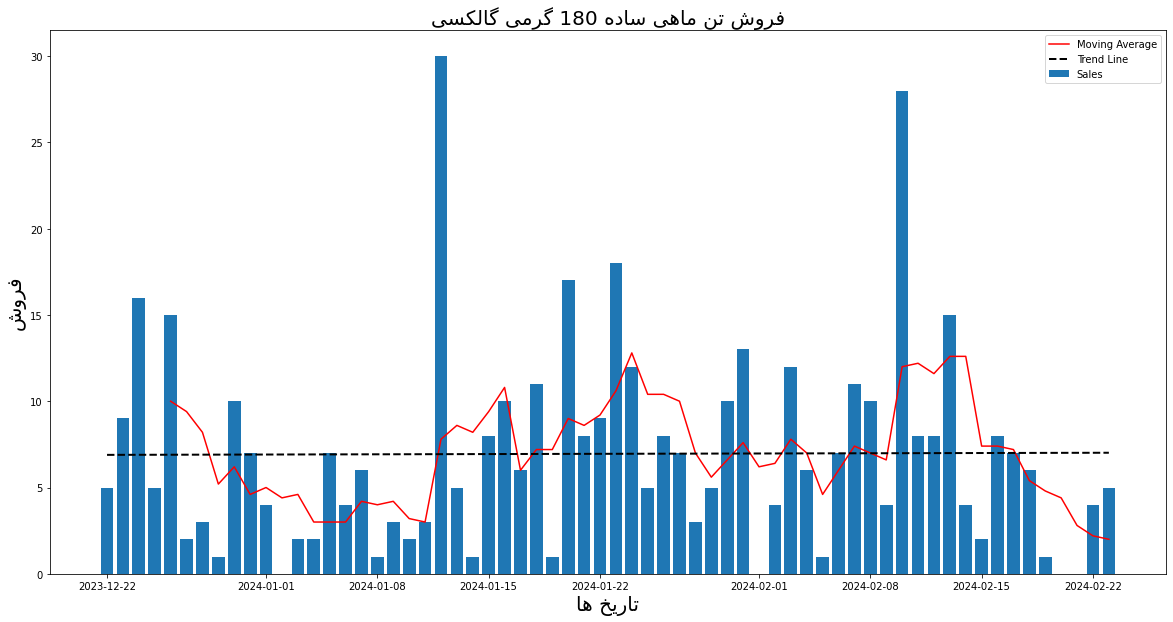

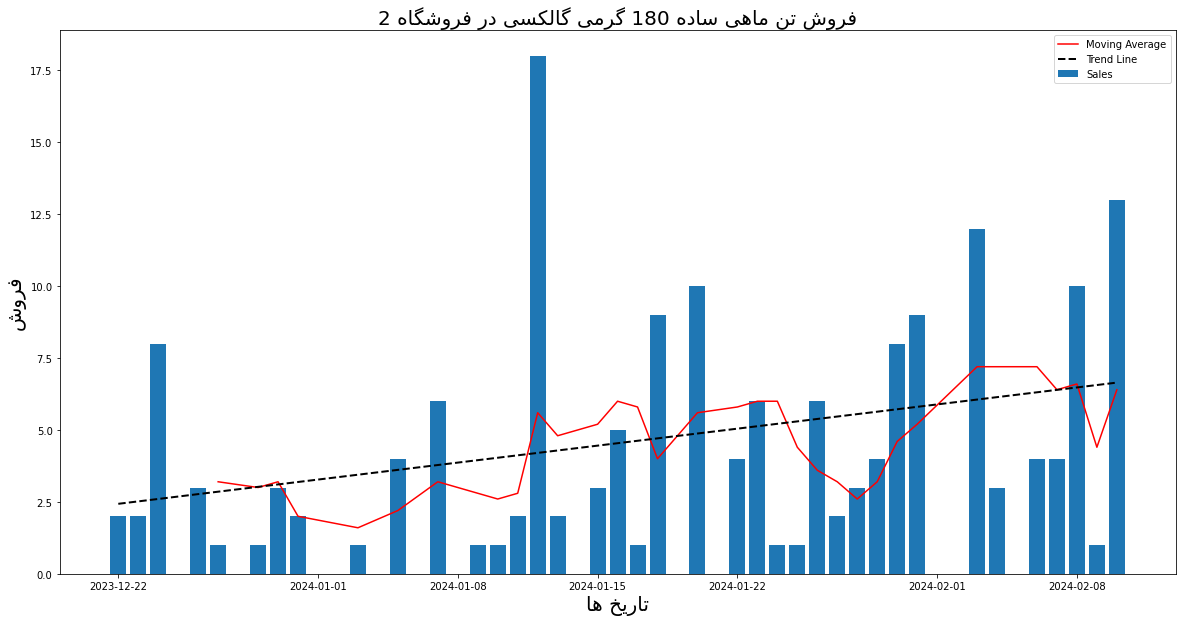

In [9]:
#df[df.columns[2]].unique()[1]
df_1=df[df[df.columns[1]]==(df[df.columns[1]].unique()[commodity])].sort_index()
df_1=df_1.resample('D').sum()
df_1[df_1.columns[1]]=df[df.columns[1]].unique()[commodity]
moving_average=df_1[df_1.columns[0]].rolling(window=window_size).mean()
plt.figure(figsize=(20, 10))
plt.bar(df_1.index,df_1[df_1.columns[0]],label='Sales')
plt.plot(df_1.index[window_size-1:], moving_average[window_size-1:], color='red', label='Moving Average')
plt.xlabel(get_display(reshape('تاریخ ها')),fontsize=20)
plt.ylabel(get_display(reshape('فروش')),fontsize=20)
plt.title(get_display(reshape('فروش '+df[df.columns[1]].unique()[commodity])),fontsize=20)
x = mdates.date2num(df_1.index)
y = df_1[df_1.columns[0]]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(df_1.index, p(x), "k--",label='Trend Line',linewidth=2)
plt.legend()

if shop!=0:
    df_2=df[df[df.columns[-1]]==(shop)].sort_index()
    df_2=df_2[df_2[df_2.columns[1]]==(df[df.columns[1]].unique()[commodity])].sort_index()
    moving_average=df_2[df_2.columns[0]].rolling(window=window_size).mean()
    plt.figure(figsize=(20, 10))
    plt.bar(df_2.index,df_2[df_2.columns[0]],label='Sales')
    plt.plot(df_2.index[window_size-1:], moving_average[window_size-1:], color='red', label='Moving Average')
    plt.xlabel(get_display(reshape('تاریخ ها')),fontsize=20)
    plt.ylabel(get_display(reshape('فروش')),fontsize=20)
    plt.title(get_display(reshape('فروش '+df[df.columns[1]].unique()[commodity]+f' در فروشگاه {shop}')),fontsize=20)
    x = mdates.date2num(df_2.index)
    y = df_2[df_2.columns[0]]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(df_2.index, p(x), "k--",label='Trend Line',linewidth=2)
    plt.legend()
plt.show()


In [10]:
split_time = 32
time_train = df_1.index[:split_time]
x_train = df_1[df_1.columns[0]][:split_time]
time_valid = df_1.index[split_time:]
x_valid = df_1[df_1.columns[0]][split_time:]
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

window_size = 30
batch_size = 16
shuffle_buffer_size = 30

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

In [294]:
init_weights = model.get_weights()


In [5]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))


optimizer = tf.keras.optimizers.SGD(momentum=0.9)


model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)


history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])



Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 112.2141 - lr: 1.0000e-08
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 112.1922 - lr: 1.1220e-08
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 112.1481 - lr: 1.2589e-08
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 112.0807 - lr: 1.4125e-08
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 111.9880 - lr: 1.5849e-08
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 111.8686 - lr: 1.7783e-08
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 111.7209 - lr: 1.9953e-08
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 111.5429 - lr: 2.2387e-08
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 111.3322 - lr: 2.5119e-08
Epoch 10/100
1/1 [==============================] - 0s 31ms/step - loss: 111.0858 - lr: 2.8184e-08
Epoch 11/100
1/1 [===

Epoch 85/100
1/1 [==============================] - 0s 31ms/step - loss: 3.1792 - lr: 1.5849e-04
Epoch 86/100
1/1 [==============================] - 0s 15ms/step - loss: 15.4591 - lr: 1.7783e-04
Epoch 87/100
1/1 [==============================] - 0s 31ms/step - loss: 11.5666 - lr: 1.9953e-04
Epoch 88/100
1/1 [==============================] - 0s 21ms/step - loss: 5.7829 - lr: 2.2387e-04
Epoch 89/100
1/1 [==============================] - 0s 22ms/step - loss: 18.4198 - lr: 2.5119e-04
Epoch 90/100
1/1 [==============================] - 0s 31ms/step - loss: 140.4202 - lr: 2.8184e-04
Epoch 91/100
1/1 [==============================] - 0s 31ms/step - loss: 9.5604 - lr: 3.1623e-04
Epoch 92/100
1/1 [==============================] - 0s 16ms/step - loss: 91.2623 - lr: 3.5481e-04
Epoch 93/100
1/1 [==============================] - 0s 16ms/step - loss: 7.9722 - lr: 3.9811e-04
Epoch 94/100
1/1 [==============================] - 0s 16ms/step - loss: 129.0329 - lr: 4.4668e-04
Epoch 95/100
1/1 [====

(1e-08, 0.001, 0.0, 100.0)

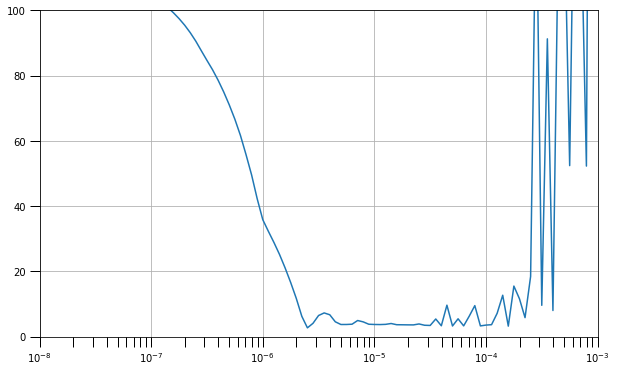

In [6]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 100])

In [7]:
tf.keras.backend.clear_session()

model.set_weights(init_weights)

In [8]:

learning_rate = 10e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [9]:
history = model.fit(train_set,epochs=100)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 112.2141 - mae: 112.7141
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 89.9852 - mae: 90.4852
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 58.4229 - mae: 58.9229
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 31.4893 - mae: 31.9893
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 13.8419 - mae: 14.3419
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 5.0761 - mae: 5.5761
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 10.8439 - mae: 11.3439
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 10.1517 - mae: 10.6517
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 6.2979 - mae: 6.7979
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 3.7870 - mae: 4.2870
Epoch 11/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 19ms/step - loss: 0.7135 - mae: 1.2135
Epoch 89/100
1/1 [==============================] - 0s 15ms/step - loss: 0.4189 - mae: 0.9142
Epoch 90/100
1/1 [==============================] - 0s 16ms/step - loss: 0.5603 - mae: 1.0599
Epoch 91/100
1/1 [==============================] - 0s 16ms/step - loss: 0.8353 - mae: 1.3353
Epoch 92/100
1/1 [==============================] - 0s 16ms/step - loss: 0.3330 - mae: 0.7923
Epoch 93/100
1/1 [==============================] - 0s 16ms/step - loss: 0.2622 - mae: 0.6862
Epoch 94/100
1/1 [==============================] - 0s 16ms/step - loss: 0.4583 - mae: 0.9312
Epoch 95/100
1/1 [==============================] - 0s 16ms/step - loss: 0.7027 - mae: 1.2010
Epoch 96/100
1/1 [==============================] - 0s 31ms/step - loss: 0.5310 - mae: 1.0095
Epoch 97/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2741 - mae: 0.6693
Epoch 98/100
1/1 [==============================] - 0s 31ms/step - loss: 

In [142]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    
    if type(y) is tuple:
        
        for y_curr in y:

            plt.plot(x[start:end], y_curr[start:end], format)

    else:
        plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)

    plt.ylabel(ylabel)

    if legend:
        plt.legend(legend)
    plt.title(title)

    plt.grid(True)

    plt.show()

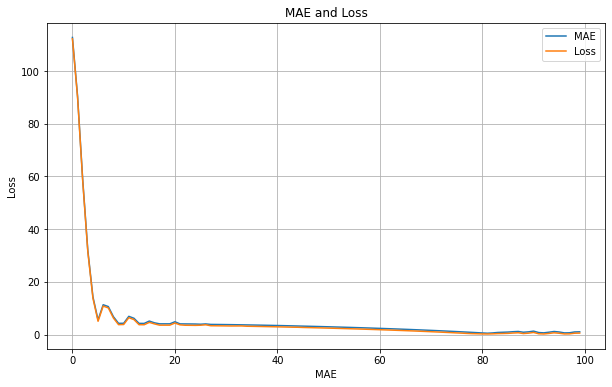

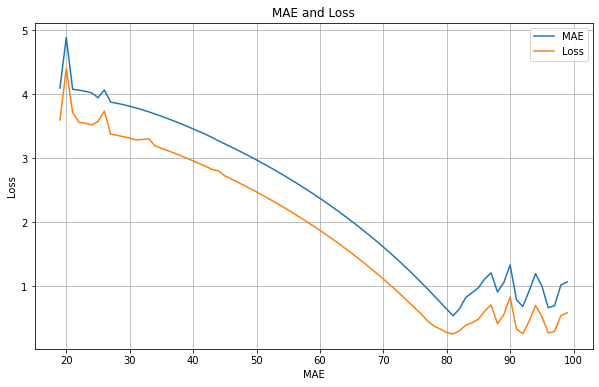

In [11]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) 

plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [12]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    forecast = model.predict(dataset)
    
    return forecast

2/2 [==============================] - 1s 16ms/step


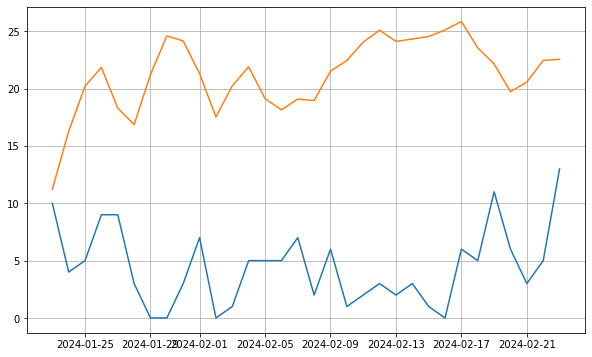

16.777748


In [13]:
forecast_series = df_1[df_1.columns[0]][split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [11]:
x = mdates.date2num(df_2.index)
y = df_2[df_2.columns[0]]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
df_3=pd.DataFrame()
df_3['Sum of Week']=df_2.resample('W').sum()[df_2.columns[0]]
result_df = pd.merge( df_2.asfreq('D'),df_3.divide(7).asfreq('D'), left_index=True, right_index=True, how='outer')
result_df['Day of Week']=(result_df.index).map(lambda x: x.weekday())
result_df[result_df.columns[0]]=result_df[result_df.columns[0]].fillna(0)
result_df[result_df.columns[1]]=df[df.columns[1]].unique()[commodity]
result_df[result_df.columns[2]]=shop
bool_series = result_df['Day of Week'] == 0
first_occurrence_index = bool_series.idxmax()
result_df=result_df.fillna(method='bfill')
result_df=result_df.loc[first_occurrence_index:]
result_df['A']=result_df[result_df.columns[0]]/result_df['Sum of Week']
andis=pd.DataFrame()
andis['Value']=0
forecast=pd.DataFrame({'Sale': [],'Day of Week':[],'Order Amount':[]})
for i in range(7):
    new_row = pd.DataFrame({'Value': [result_df[result_df['Day of Week']==i]['A'].mean()]},index=[i])
    andis = pd.concat([andis, new_row])
for i in range(1,31):
    new_row = pd.DataFrame({'Sale': [andis.iloc[(result_df.index[-1]+timedelta(days=i)).weekday()][0]*p(mdates.date2num(result_df.index[-1]+timedelta(days=i)))],'Day of Week':[(result_df.index[-1]+timedelta(days=i)).weekday()]},index=[result_df.index[-1]+timedelta(days=i)])
    forecast=pd.concat([forecast, new_row])

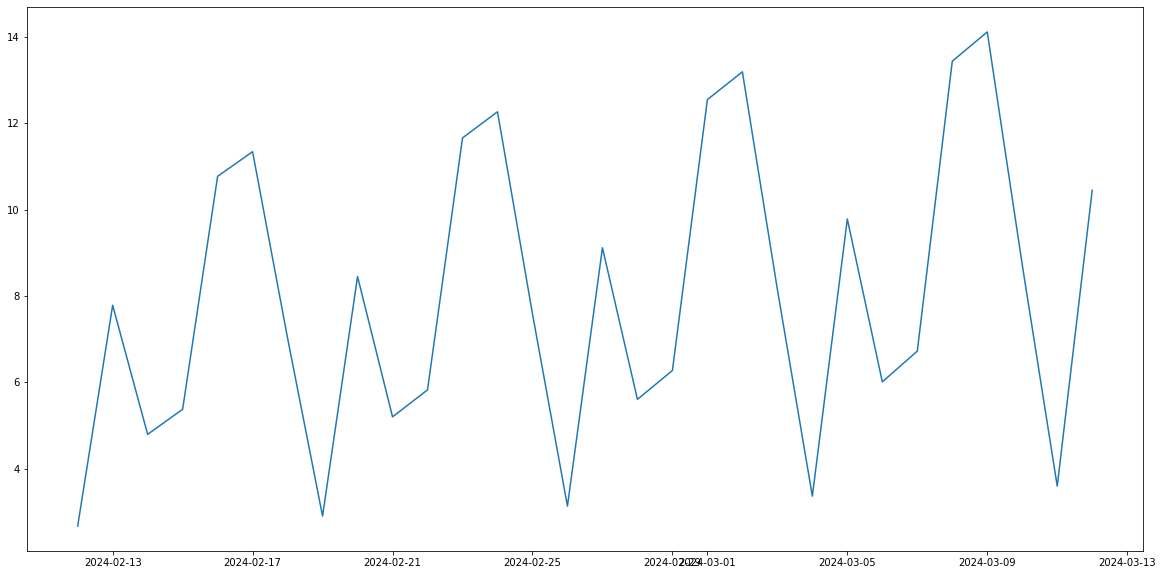

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(forecast.index,forecast[forecast.columns[0]])
plt.show()

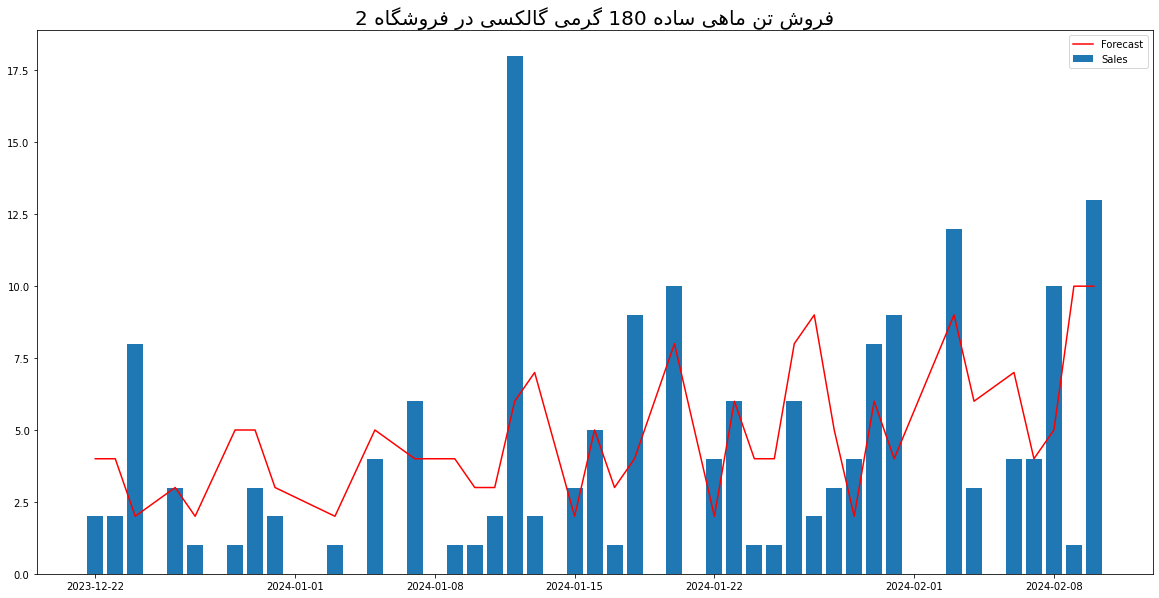

1.125


In [13]:
df_2['Forecast_R']=p(x)
df_2['Day of Week']=(df_2.index).map(lambda x: x.weekday())
df_2['Andis']=df_2['Day of Week'].map(lambda x:andis.iloc[x][0])
df_2['Forecast']=(df_2['Andis']*df_2['Forecast_R']).round()
df_2['Error']=df_2['Forecast']-df_2[df_2.columns[0]]
plt.figure(figsize=(20, 10))
plt.bar(df_2.index,df_2[df_2.columns[0]],label='Sales',)
plt.plot(df_2.index,df_2['Forecast'],label='Forecast',color='r')
plt.legend()
plt.title(get_display(reshape('فروش '+df[df.columns[1]].unique()[commodity]+f' در فروشگاه {shop}')),fontsize=20)
plt.show()
error=(df_2['Error'].resample('W').sum()).mean()
print(error)

In [14]:
forecast['Sale']=forecast['Sale'].round()
cumulative_sum = 0
if policy==1:
    forecast = forecast.iloc[::-1]
    for index, row in forecast.iterrows():
        day=delivery[str(shop)][0]-1
        if day<0:
            day=6
        if True :
            cumulative_sum += row['Sale']
            forecast.at[index, 'Order Amount'] = cumulative_sum - error + ss
            cumulative_sum = 0
        else:
            cumulative_sum += row['Sale']
    else:
        forecast.at[index, 'Order Amount'] = cumulative_sum - error + ss - inventory.loc[df[df.columns[1]].unique()[commodity]][0]
    forecast = forecast.iloc[::-1]
else:    
    forecast = forecast.iloc[::-1]
    for i in range(len(delivery[str(shop)])):
        if delivery[str(shop)][i] - 1>=0:
            delivery[str(shop)][i]=delivery[str(shop)][i] - 1
        else:
            delivery[str(shop)][i]=6
    for index, row in forecast.iterrows():
        if row['Day of Week'] in delivery[str(shop)]:
            cumulative_sum += 0
            forecast.at[index, 'Order Amount'] = cumulative_sum - error + ss
            cumulative_sum = row['Sale']
        else:
            cumulative_sum += row['Sale']
    else:
        forecast.at[index, 'Order Amount'] = cumulative_sum - error + ss - inventory.loc[df[df.columns[1]].unique()[commodity]][0]
    forecast = forecast.iloc[::-1]
forecast

,Sale,Day of Week,Order Amount
2024-02-12,3.0,0.0,9.875
2024-02-13,8.0,1.0,22.875
2024-02-14,5.0,2.0,NaN
2024-02-15,5.0,3.0,NaN
2024-02-16,11.0,4.0,19.875
2024-02-17,11.0,5.0,NaN
2024-02-18,7.0,6.0,12.875
2024-02-19,3.0,0.0,NaN
2024-02-20,8.0,1.0,24.875
2024-02-21,5.0,2.0,NaN


In [302]:
for index, row in forecast.iterrows():
    if row['Order Amount']>0:
        print(f"در روز {(get_weekday_name(int(row['Day of Week'])))} مورخ {index.date()} به مقدار {int(row['Order Amount'])} واحد {df[df.columns[1]].unique()[commodity]} سفارش داده شود")

در روز چهارشنبه مورخ 2024-02-28 به مقدار 11 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز شنبه مورخ 2024-03-02 به مقدار 9 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز دوشنبه مورخ 2024-03-04 به مقدار 7 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز چهارشنبه مورخ 2024-03-06 به مقدار 10 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز شنبه مورخ 2024-03-09 به مقدار 7 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز دوشنبه مورخ 2024-03-11 به مقدار 6 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز چهارشنبه مورخ 2024-03-13 به مقدار 8 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز شنبه مورخ 2024-03-16 به مقدار 7 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز دوشنبه مورخ 2024-03-18 به مقدار 6 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز چهارشنبه مورخ 2024-03-20 به مقدار 8 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز شنبه مورخ 2024-03-23 به مقدار 7 واحد اسپاگتی 1.5 زر 700 گرم سفارش داده شود
در روز دوشنبه مورخ 2024-03-25 به مقدار 4 واحد اسپاگتی 1.5 زر 700 گرم سفارش

In [303]:
result_df

,مقدار فروش,نام کالا,کد فروشگاه,Forecast_R,Sum of Week,Day of Week,A
تاریخ شمسی,,,,,,,
2023-12-25,1.0,اسپاگتی 1.5 زر 700 گرم,3,5.544674,5.571429,0,0.179487
2023-12-26,4.0,اسپاگتی 1.5 زر 700 گرم,3,5.499321,5.571429,1,0.717949
2023-12-27,9.0,اسپاگتی 1.5 زر 700 گرم,3,5.453969,5.571429,2,1.615385
2023-12-28,5.0,اسپاگتی 1.5 زر 700 گرم,3,5.408616,5.571429,3,0.897436
2023-12-29,6.0,اسپاگتی 1.5 زر 700 گرم,3,5.363263,5.571429,4,1.076923
...,...,...,...,...,...,...,...
2024-02-21,3.0,اسپاگتی 1.5 زر 700 گرم,3,2.914220,3.571429,2,0.840000
2024-02-22,1.0,اسپاگتی 1.5 زر 700 گرم,3,2.868867,3.571429,3,0.280000
2024-02-23,13.0,اسپاگتی 1.5 زر 700 گرم,3,2.823514,3.571429,4,3.640000
